# Basic photometric analyses

gPhoton2 extracts photometric measurements using the aperture photometry tools of `astropy`'s `photutils` package.

In [8]:
from rich import print
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from gPhoton import analysis

In [2]:
edir = 'test_data/e23456/'
photomfiles = {'APER4':f'{edir}/e23456-nd-f0060-b00-movie-photom-12_8.csv',
               'APER5':f'{edir}/e23456-nd-f0060-b00-movie-photom-17_3.csv',
               'APER6':f'{edir}/e23456-nd-f0060-b00-movie-photom-30_0.csv',}

First we will open a photometry file that has been output directly from gPhoton2. Cross-referencing the [filenaming reference](#filenaming_conventions.md) will permit you to identify that this is a photometry file for the 0th leg of eclipse 23456 in the NUV band with 60-second time bins and 12.8" radius apertures. This aperture radius corresponds to what the mission designated 

In [12]:
aper4_photom = pd.read_csv(f'{edir}/e23456-nd-f0060-b00-movie-photom-12_8.csv')
aper4_photom.head()

,xcentroid,ycentroid,area,segment_flux,elongation,eccentricity,equivalent_radius,orientation,max_value,maxval_xindex,...,artifact_flag_19,artifact_flag_20,artifact_flag_21,artifact_flag_22,artifact_flag_23,artifact_flag_24,artifact_flag_25,artifact_flag_26,artifact_flag_27,artifact_flag_28
0,1475.455495,77.000000,2.0,-1.262053,1.994049,0.865162,0.797885,0.000000,-0.081044,1475,...,12,12,12,12,12,12,12,12,12,12
1,1526.000000,83.499629,2.0,12.307364,2.000000,0.866025,0.797885,90.000000,9.614330,1526,...,13,12,13,12,13,12,13,4,13,12
2,1515.351158,93.584657,92.0,872.138351,2.256933,0.896482,5.411516,85.961426,27.325287,1516,...,12,4,12,4,12,4,12,4,12,12
3,1402.531181,88.510167,4.0,28.404093,1.006050,0.109504,1.128379,53.391200,11.763075,1403,...,12,12,12,12,12,12,12,4,12,12
4,1444.994432,89.000000,3.0,14.752273,2.988250,0.942345,0.977205,0.000000,8.529310,1444,...,12,12,12,12,12,12,12,12,12,12


Note that there is a huge number of columns in the photometry files. The exact number depends on the observing mode, because many columns are repeated for every frame of a movie, if the photometry was performed on a movie file. These repeating frames will be appended with a frame index `_[N]`. The column definitions more fully described in **[REFERENCE TBD]**.

The columns that we care about the most right now will be:
| Column | Description |
|--------|-------------|
| [xy]centroid | Centroid of the source in count image pixel coordinates
| [xy]center | Center of the aperture in count image pixel coordinates
| ra | Right ascention of aperture center in J2000 decimal degrees
| dec | Declination of aperture center in J2000 decimal degrees
| aperture_sum[_N] | Integrated counts within the aperture (pixel values, interpolated)
| artifact_flag[_N] | Artifact flag of pixels within the aperture
| t0[_N] | Start time in "GALEX time"
| t1[_N] | Stop time in "GALEX time"
| expt[_N] | Effective exposure time in seconds

In [13]:
for k in aper4_photom.columns:
    print(k, end=', ')
print()

xcentroid,

ycentroid,

area,

segment_flux,

elongation,

eccentricity,

equivalent_radius,

orientation,

max_value,

maxval_xindex,

maxval_yindex,

min_value,

minval_xindex,

minval_yindex,

bbox_xmin,

bbox_xmax,

bbox_ymin,

bbox_ymax,

threshold_multiplier,

threshold_minimum,

extended_source,

xcenter,

ycenter,

aperture_sum,

ya_aperture_sum,

stdcolrow_aperture_sum,

q_aperture_sum,

artifact_flag,

ra,

dec,

aperture_sum_0,

aperture_sum_1,

aperture_sum_2,

aperture_sum_3,

aperture_sum_4,

aperture_sum_5,

aperture_sum_6,

aperture_sum_7,

aperture_sum_8,

aperture_sum_9,

aperture_sum_10,

aperture_sum_11,

aperture_sum_12,

aperture_sum_13,

aperture_sum_14,

aperture_sum_15,

aperture_sum_16,

aperture_sum_17,

aperture_sum_18,

aperture_sum_19,

aperture_sum_20,

aperture_sum_21,

aperture_sum_22,

aperture_sum_23,

aperture_sum_24,

aperture_sum_25,

aperture_sum_26,

aperture_sum_27,

aperture_sum_28,

expt_0,

expt_1,

expt_2,

expt_3,

expt_4,

expt_5,

expt_6,

expt_7,

expt_8,

expt_9,

expt_10,

expt_11,

expt_12,

expt_13,

expt_14,

expt_15,

expt_16,

expt_17,

expt_18,

expt_19,

expt_20,

expt_21,

expt_22,

expt_23,

expt_24,

expt_25,

expt_26,

expt_27,

expt_28,

t0_0,

t0_1,

t0_2,

t0_3,

t0_4,

t0_5,

t0_6,

t0_7,

t0_8,

t0_9,

t0_10,

t0_11,

t0_12,

t0_13,

t0_14,

t0_15,

t0_16,

t0_17,

t0_18,

t0_19,

t0_20,

t0_21,

t0_22,

t0_23,

t0_24,

t0_25,

t0_26,

t0_27,

t0_28,

t1_0,

t1_1,

t1_2,

t1_3,

t1_4,

t1_5,

t1_6,

t1_7,

t1_8,

t1_9,

t1_10,

t1_11,

t1_12,

t1_13,

t1_14,

t1_15,

t1_16,

t1_17,

t1_18,

t1_19,

t1_20,

t1_21,

t1_22,

t1_23,

t1_24,

t1_25,

t1_26,

t1_27,

t1_28,

artifact_flag_0,

artifact_flag_1,

artifact_flag_2,

artifact_flag_3,

artifact_flag_4,

artifact_flag_5,

artifact_flag_6,

artifact_flag_7,

artifact_flag_8,

artifact_flag_9,

artifact_flag_10,

artifact_flag_11,

artifact_flag_12,

artifact_flag_13,

artifact_flag_14,

artifact_flag_15,

artifact_flag_16,

artifact_flag_17,

artifact_flag_18,

artifact_flag_19,

artifact_flag_20,

artifact_flag_21,

artifact_flag_22,

artifact_flag_23,

artifact_flag_24,

artifact_flag_25,

artifact_flag_26,

artifact_flag_27,

artifact_flag_28,

### Photometry on the full depth observation

In [3]:
photom_aper4 = pd.read_csv(photomfiles['APER4'])
# The following will be unnecessary once `expt` is added as a column
nframes = len([True for k in photom_aper4.keys() if 'expt_' in k])
expt_total = sum([photom_aper4[k][0] for k in photom_aper4.keys() if 'expt_' in k])
photom_aper4['expt'] = pd.Series(np.full(len(photom_aper4),
                                         expt_total))
# Note that the `expt` is the same for all sources in an observation
# This means that it will only be valid for sources observed _at full depth_
# We will explain how to screen sources that were not observed at full depth later

range: 0.5418304085734884 563.4274167920412


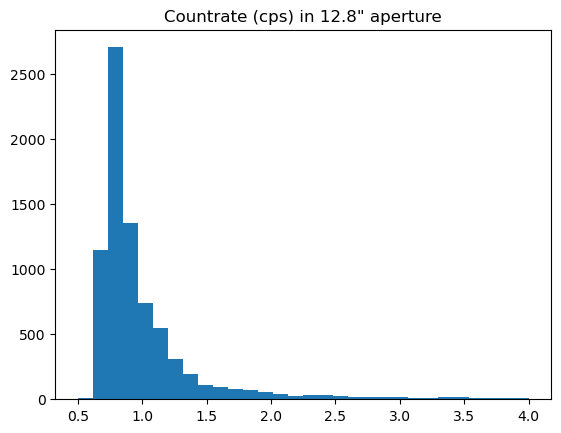

In [4]:
# Counts per second is just aperture_sum / expt
counts_per_second_aper4 = photom_aper4['aperture_sum'] / photom_aper4['expt']
print('range:',
      np.nanmin(counts_per_second_aper4),
      counts_per_second_aper4.iloc[np.where(np.isfinite(counts_per_second_aper4))].max())
plt.hist(counts_per_second_aper4, bins=30, range=(0.5,4))
plt.title('Countrate (cps) in 12.8" aperture')

# The standard error is just sqrt(N)/expt
counts_per_second_std_err_aper4 = np.sqrt(photom_aper4['aperture_sum']) / photom_aper4['expt']

range: 0.555401522739948 36.15925211424764


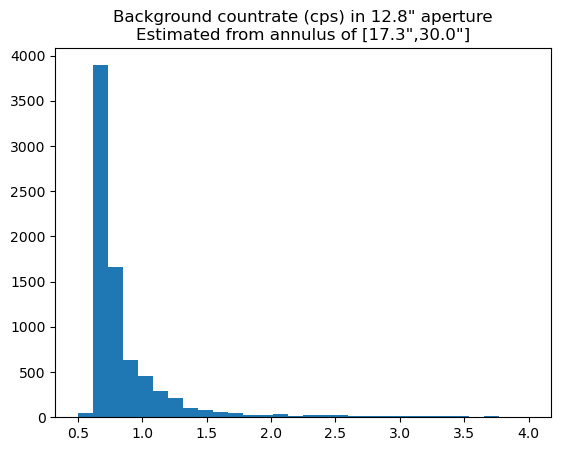

In [5]:
# Estimate background in an annulus
photom_aper5 = pd.read_csv(photomfiles['APER5'])
photom_aper6 = pd.read_csv(photomfiles['APER6'])
# exposure time should be the same for all apertures
counts_per_second_aper5 = photom_aper5['aperture_sum'] / photom_aper4['expt']
counts_per_second_aper6 = photom_aper6['aperture_sum'] / photom_aper4['expt']

aperture_area = np.pi*(12.8**2)
annulus_area = np.pi*(30.0**2 - 17.3**2)
aperture_sum_aper5 = photom_aper5['aperture_sum']
aperture_sum_aper6 = photom_aper6['aperture_sum']
background_counts_per_second_aper4 = (aperture_sum_aper6 - aperture_sum_aper5) * (aperture_area / annulus_area) / photom_aper4['expt']

print('range:',
      np.nanmin(background_counts_per_second_aper4),
      background_counts_per_second_aper4.iloc[np.where(np.isfinite(background_counts_per_second_aper4))].max())
plt.hist(background_counts_per_second_aper4, bins=30, range=(0.5,4))
plt.title(f'Background countrate (cps) in 12.8" aperture\nEstimated from annulus of [17.3",30.0"]')

# The standard error is just sqrt(N)/expt
background_counts_per_second_std_err_aper4 = np.sqrt(aperture_sum_aper6 - aperture_sum_aper5) / photom_aper4['expt']


range: -31.167074239470303 553.3936219571112


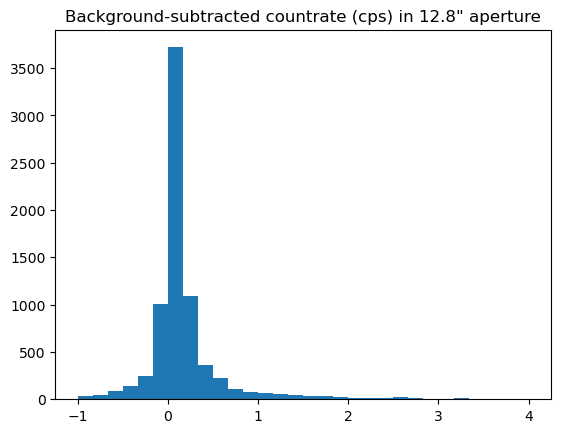

In [6]:
# Calculate the background-subtracted countrate
counts_per_second_bgsub_aper4 = counts_per_second_aper4 - background_counts_per_second_aper4
print('range:',
      counts_per_second_bgsub_aper4.iloc[np.where(np.isfinite(counts_per_second_bgsub_aper4))].min(),
      counts_per_second_bgsub_aper4.iloc[np.where(np.isfinite(counts_per_second_bgsub_aper4))].max())
plt.hist(counts_per_second_bgsub_aper4, bins=30, range=(-1,4))
plt.title('Background-subtracted countrate (cps) in 12.8" aperture')

# The standard error is computed by addition in quadrature
counts_per_second_bgsub_std_err_aper4 = np.sqrt(counts_per_second_std_err_aper4**2 + background_counts_per_second_std_err_aper4**2) / photom_aper4['expt']

You will have noted that doing background estimation and subtraction in this way generates a large number of _negative_ fluxes. This is due to three main factors.
1. The annulus capturing some of the light of the main source.
2. Sources contaminating the annulus with stray light.
3. Failure to take into account that the GALEX diffuse sky background is Poissonian (mostly).

We will attempt to mitigate these problems in the next notebook by using a better model.

### Aperture corrections

There are two published aperture correction tables. Both map an aperture correction to the standard GALEX aperture radii in both bands.

The first is described in Figure 4 from Morissey, et al., 2007. It maps to `APER[0-9]`. We believe that this is the more reliable of the published aperture corrections, and it is the one that the mission team used.

The second is described in Table 1 from http://www.galex.caltech.edu/researcher/techdoc-ch5.html. It only maps to `APER[0-6]`, which are the apertures most appropriate for the majority of scientific analyses.

The following functions take an aperture radius in decimal degrees and interpolate a aperture correction based on these two published references. You can see that the proposed corrections different quite a lot.

In [ ]:
# In our example we use a 12.8" aperture, which is 12.8/3600 degrees
aperture_radius = 12.8/3600.
apcor1 = analysis.utils.apcorrect1(aperture_radius, 'NUV')
apcor2 = analysis.utils.apcorrect2(aperture_radius, 'NUV')
print(f'Aperture correction (method 1, Morissey+2007): {apcor1:.3f} mag (BEST OPTION)')
print(f'Aperture correction (method 2, GALEX tech doc): {apcor2:.3f} mag')

Aperture correction (method 1, Morissey+2007): 0.090 mag (BEST OPTION)
Aperture correction (method 2, GALEX tech doc): 0.060 mag


In [ ]:
# In cps or linear flux units, the aperture correction is just a multiplicative factor
counts_per_second_bgsub_aper4_corrected = counts_per_second_bgsub_aper4 * (1 + apcor1)

The uncertainties associated with the aperture corrections are unknown.

In magnitudes, the aperture correction should be _subtracted_. We'll discuss how to convert to magnitude units next.

### Converting to other flux units

The conversion facts from counts-per-second (cps) to other standard flux units are described at http://asd.gsfc.nasa.gov/archive/galex/FAQ/counts_background.html.

The following functions will convert between cps, AB Mag, and flux (erg sec^-1 cm^-2 A^-1).